### Blur detection


In [7]:
# import the necessary packages
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
from skimage import measure


def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()


def compute_blur_metric(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return measure.blur_effect(gray)


def is_image_blurred(image, threshold=100.0):
    # load the image, convert it to grayscale, and compute the
    # focus measure of the image using the Variance of Laplacian
    # method
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    # compute blur metric
    blur_metric = compute_blur_metric(image)
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    status_blurred = False
    if laplacian_var < threshold:
        status_blurred = True
    return status_blurred, laplacian_var, blur_metric

Status:
	is_blurred: True
	laplacian_var: 3.3767863260613544
	blur_metric: 0.5564765661706466


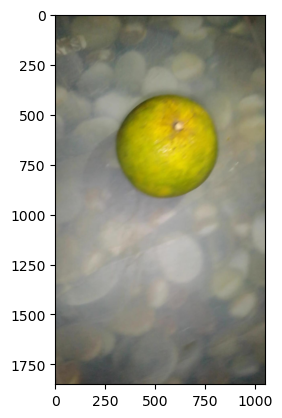

In [9]:
image = cv2.imread("<PATH TO IMAGE>")
is_blurred, laplacian_var, blur_metric = is_image_blurred(image)
print(
    f"Status:\n\tis_blurred: {is_blurred}\n\tlaplacian_var: {laplacian_var}\n\tblur_metric: {blur_metric}"
)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Deblurring


In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.misc
from skimage import color, restoration
from scipy.signal import convolve2d


# better to use weiner - it is faster with same +- results
def deblur_wiener(image):
    psf = np.ones((5, 5)) / 25
    deblurred_image = restoration.wiener(image, psf, 0.01)
    return deblurred_image


# auto wiener version
def deblur_wiener_auto(image):
    psf = np.ones((5, 5)) / 25
    deblurred_image, _ = restoration.unsupervised_wiener(image, psf)
    return deblurred_image


def deblur_richardson_lucy(image):
    psf = np.ones((5, 5)) / 25
    deblurred_image = restoration.richardson_lucy(image, psf, 5)
    return deblurred_image


def deblur_driver(image, method="wiener"):
    # Convert the image to floating point type and normalize the values to the range [0, 1]
    image = image.astype(np.float32) / 255.0
    # Split the image into separate color channels
    B, G, R = cv2.split(image)
    if method == "wiener":
        # Apply Wiener deconvolution to each channel separately
        deblurred_channels = [deblur_wiener(channel) for channel in [B, G, R]]
    if method == "wiener_auto":
        # Apply Wiener deconvolution to each channel separately
        deblurred_channels = [deblur_wiener_auto(channel) for channel in [B, G, R]]
    elif method == "richardson_lucy":
        # Apply Richardson-Lucy deconvolution to each channel separately
        deblurred_channels = [deblur_richardson_lucy(channel) for channel in [B, G, R]]
    # Merge the deblurred color channels back into an RGB image
    deblurred_image = cv2.merge(deblurred_channels)
    # Convert deblurred image back to 8-bit unsigned integer format
    deblurred_image = np.clip(deblurred_image * 255, 0, 255).astype(np.uint8)
    return deblurred_image

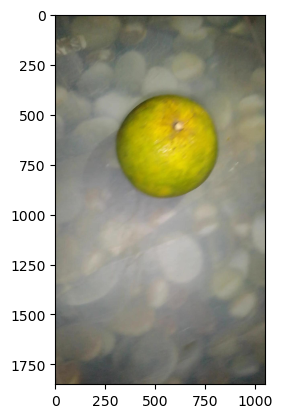

In [11]:
# Read the input image
image = cv2.imread("<PATH TO IMAGE>")
deblurred_image = deblur_driver(image)
plt.imshow(cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB))

### Detect Blur - Deblur


In [13]:
def detect_deblur_driver(path_to_image):
    image = cv2.imread(path_to_image)
    before_is_blurred, before_laplacian_var, before_blur_metric = is_image_blurred(
        image
    )
    deblurred_image = deblur_driver(image)
    after_is_blurred, after_laplacian_var, after_blur_metric = is_image_blurred(
        deblurred_image
    )
    return (
        image,
        (before_is_blurred, before_laplacian_var, before_blur_metric),
        deblurred_image,
        (after_is_blurred, after_laplacian_var, after_blur_metric),
    )


path_to_image = "<PATH TO IMAGE>"
(
    image,
    (before_is_blurred, before_laplacian_var, before_blur_metric),
    deblurred_image,
    (after_is_blurred, after_laplacian_var, after_blur_metric),
) = detect_deblur_driver(path_to_image)

Status before deblur:
	is_blurred: True
	laplacian_var: 3.3767863260613544
	blur_metric: 0.5564765661706466
Status after deblur:
	is_blurred: True
	laplacian_var: 99.74965744765666
	blur_metric: 0.19770326644197136


Text(0.5, 1.0, 'After deblur')

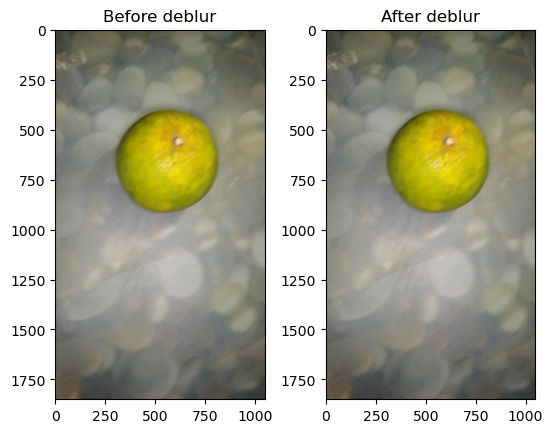

In [15]:
print(
    f"Status before deblur:\n\tis_blurred: {before_is_blurred}\n\tlaplacian_var: {before_laplacian_var}\n\tblur_metric: {before_blur_metric}"
)
print(
    f"Status after deblur:\n\tis_blurred: {after_is_blurred}\n\tlaplacian_var: {after_laplacian_var}\n\tblur_metric: {after_blur_metric}"
)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Before deblur")
ax[1].imshow(cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB))
ax[1].set_title("After deblur")